In [1]:
import rawpy
import imageio
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
from torchvision import models
from matplotlib import pyplot as plt
import torch
from torchsummary import summary
from collections import defaultdict
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch
import torch.nn as nn
# from loss import dice_loss
from tqdm import tqdm
import random
import pickle

In [2]:
with open('/home/ad/dng/raw_list.pkl','rb') as f:
    raw_list = pickle.load(f)
    raw_array = np.stack(raw_list)
    del raw_list
    raw_array[raw_array>255] = 255
    raw_array = raw_array.astype(np.float32)/255.0
with open('/home/ad/dng/rgb_list.pkl','rb') as f:
    rgb_list = pickle.load(f)
    rgb_array = np.stack(rgb_list)
    del rgb_list
    rgb_array = rgb_array.astype(np.float32)/255.0

In [16]:
class SimDataset(Dataset):
    def __init__(self, raw_array, rgb_array,count, transform=None):
        # self.flist = []
        self.size = 64
        self.stride = 2
        self.count = count
        self.raw_array = raw_array
        self.rgb_array = rgb_array
        # for x in tqdm(path.iterdir()):
        #     if x.is_file():
        #         self.flist.append(x)
        #         raw = rawpy.imread(str(x))
        #         self.raw_list.append(raw.raw_image)
        #         self.rgb_list.append(raw.postprocess())

#         self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.transform = transform
        self.source_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.479], [0.212]) # dng
        ])
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):  
        stride = self.stride
        sample_num = idx%len(self.raw_array)
#         raw = rawpy.imread(str(self.flist[idx]))
        raw_image = self.raw_array[sample_num]
        rgb = self.rgb_array[sample_num]
        x = random.randint(0,int((raw_image.shape[0]-train_set.size-1)/stride))
        y = random.randint(0,int((raw_image.shape[1]-train_set.size-1)/stride))
        raw_crop = raw_image[stride*x:stride*x+self.size,stride*y:stride*y+self.size]
        rgb_crop = rgb[stride*x:stride*x+self.size,stride*y:stride*y+self.size]
#         if self.transform:
#             raw_image = self.transform(raw_image.astype(np.float32))
#             rgb = self.transform(rgb)
        return [self.source_transform(raw_crop), self.target_transform(rgb_crop)]


In [17]:

directory = Path('/content/intern_task')
train_set = SimDataset(raw_array,rgb_array, 1000)

In [18]:
batch_size = 16

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2);

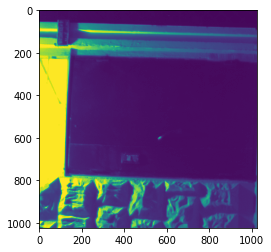

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


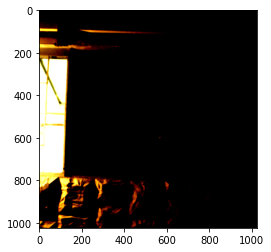

In [15]:
raw, rgb = train_set[0]
plt.imshow(raw.permute(1,2,0))
plt.show()
plt.imshow(rgb.permute(1,2,0))
plt.show()

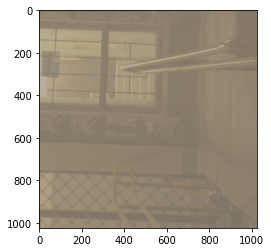

In [49]:
plt.imshow(reverse_transform(rgb))

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model = models.resnet18(pretrained=False)
base_model = base_model.to(device)

# summary(base_model, input_size=(3, 224, 224))


In [24]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        
        layer3 = self.layer3_1x1(layer3)
#         x = self.upsample(layer3)
#         print("x shape:",x.shape)
#         print("layer3 shape:",layer3.shape)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out



In [25]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(3)
model = model.to(device)

# summary(model, input_size=(3, 224, 224))

In [22]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [26]:
mse_loss = nn.MSELoss()

In [8]:
model = torch.load('resnet18.pt')

In [27]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = ResNetUNet(num_class).to(device)
# model = torch.load('resnet18.pt')
# freeze backbone layers
# Comment out to finetune further
# for l in model.base_layers:
#     for param in l.parameters():
#         param.requires_grad = False

# optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# optimizer = optim.Adam(model.parameters(),lr=1e-4)
optimizer = optim.AdamW(model.parameters(),lr=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8) 


cuda:0


In [28]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

In [29]:
num_epochs = 200
model.train()  # Set model to training mode
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train']:

        scheduler.step()
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
#             metrics = defaultdict(float)    
#         model.train()  # Set model to training mode
        losses = []
        progress = tqdm(train_dataloader)
        for inputs, labels in progress:
            inputs = inputs.to(device)
            labels = labels.to(device)             

            # forward
            # track history if only in train

            outputs = model(inputs)

            loss = mse_loss(outputs,labels)
            losses.append(loss)

            # Backpropagation
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            progress.set_description(str(loss.item()))



        writer.add_scalar('Accuracy/train', loss.item(), epoch)
        writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
    
        print("loss:", sum(losses)/len(losses))
        print(optimizer.param_groups[0]['lr'])





/home/ad/venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 0/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(1.2394, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 1/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.6760, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 2/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.5398, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 3/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.4382, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 4/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.3566, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 5/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.2932, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 6/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.2468, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 7/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.2164, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 8/199
LR 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1740, device='cuda:0', grad_fn=<DivBackward0>)
0.0001
Epoch 9/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1514, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 10/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1567, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 11/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1479, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 12/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1129, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 13/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1340, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 14/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1306, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 15/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1121, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 16/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1270, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 17/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1040, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 18/199
LR 8e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1081, device='cuda:0', grad_fn=<DivBackward0>)
8e-05
Epoch 19/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1173, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 20/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1112, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 21/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1000, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 22/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1054, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 23/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1128, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 24/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1031, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 25/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1110, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 26/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.1006, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 27/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0960, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 28/199
LR 6.400000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0909, device='cuda:0', grad_fn=<DivBackward0>)
6.400000000000001e-05
Epoch 29/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0941, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 30/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0853, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 31/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0921, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 32/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0967, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 33/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0854, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 34/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0909, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 35/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0949, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 36/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0914, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 37/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0951, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 38/199
LR 5.120000000000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0851, device='cuda:0', grad_fn=<DivBackward0>)
5.120000000000001e-05
Epoch 39/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0887, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 40/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0816, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 41/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0861, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 42/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0769, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 43/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0852, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 44/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0816, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 45/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0852, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 46/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0815, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 47/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0808, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 48/199
LR 4.0960000000000014e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0802, device='cuda:0', grad_fn=<DivBackward0>)
4.0960000000000014e-05
Epoch 49/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0786, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 50/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0742, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 51/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0706, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 52/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0812, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 53/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0759, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 54/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0748, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 55/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0763, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 56/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0808, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 57/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0743, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 58/199
LR 3.2768000000000016e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0723, device='cuda:0', grad_fn=<DivBackward0>)
3.2768000000000016e-05
Epoch 59/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0769, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 60/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0730, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 61/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0775, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 62/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0771, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 63/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0786, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 64/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0774, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 65/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0768, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 66/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0734, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 67/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0797, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 68/199
LR 2.6214400000000015e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0782, device='cuda:0', grad_fn=<DivBackward0>)
2.6214400000000015e-05
Epoch 69/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0730, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 70/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0744, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 71/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0720, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 72/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0669, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 73/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0735, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 74/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0685, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 75/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0727, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 76/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0703, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 77/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0802, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 78/199
LR 2.0971520000000012e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0755, device='cuda:0', grad_fn=<DivBackward0>)
2.0971520000000012e-05
Epoch 79/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0692, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 80/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 81/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0703, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 82/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0671, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 83/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0653, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 84/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0659, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 85/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0680, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 86/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0695, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 87/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0708, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 88/199
LR 1.677721600000001e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0786, device='cuda:0', grad_fn=<DivBackward0>)
1.677721600000001e-05
Epoch 89/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0683, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 90/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0728, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 91/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0698, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 92/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0651, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 93/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0679, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 94/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0678, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 95/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0667, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 96/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0684, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 97/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0674, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 98/199
LR 1.3421772800000009e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0682, device='cuda:0', grad_fn=<DivBackward0>)
1.3421772800000009e-05
Epoch 99/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0633, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 100/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0637, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 101/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0683, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 102/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0717, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 103/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0649, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 104/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0651, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 105/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0651, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 106/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0657, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 107/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0645, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 108/199
LR 1.0737418240000008e-05


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0710, device='cuda:0', grad_fn=<DivBackward0>)
1.0737418240000008e-05
Epoch 109/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0700, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 110/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0707, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 111/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0621, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 112/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0702, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 113/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0624, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 114/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0697, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 115/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0684, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 116/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0668, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 117/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0602, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 118/199
LR 8.589934592000007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0628, device='cuda:0', grad_fn=<DivBackward0>)
8.589934592000007e-06
Epoch 119/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0614, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 120/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0623, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 121/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0628, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 122/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0651, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 123/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0649, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 124/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0651, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 125/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0567, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 126/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0634, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 127/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0704, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 128/199
LR 6.871947673600007e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0614, device='cuda:0', grad_fn=<DivBackward0>)
6.871947673600007e-06
Epoch 129/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0621, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 130/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0647, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 131/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0683, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 132/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0601, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 133/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0621, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 134/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0624, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 135/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0672, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 136/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0649, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 137/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0697, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 138/199
LR 5.4975581388800055e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0614, device='cuda:0', grad_fn=<DivBackward0>)
5.4975581388800055e-06
Epoch 139/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0603, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 140/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0561, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 141/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0576, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 142/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0635, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 143/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0622, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 144/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0596, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 145/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0635, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 146/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0634, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 147/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0589, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 148/199
LR 4.3980465111040045e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0650, device='cuda:0', grad_fn=<DivBackward0>)
4.3980465111040045e-06
Epoch 149/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0631, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 150/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0662, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 151/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0568, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 152/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0577, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 153/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0626, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 154/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0631, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 155/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0637, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 156/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0580, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 157/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0594, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 158/199
LR 3.5184372088832037e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0619, device='cuda:0', grad_fn=<DivBackward0>)
3.5184372088832037e-06
Epoch 159/199
LR 2.8147497671065632e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0582, device='cuda:0', grad_fn=<DivBackward0>)
2.8147497671065632e-06
Epoch 160/199
LR 2.8147497671065632e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0586, device='cuda:0', grad_fn=<DivBackward0>)
2.8147497671065632e-06
Epoch 161/199
LR 2.8147497671065632e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0664, device='cuda:0', grad_fn=<DivBackward0>)
2.8147497671065632e-06
Epoch 162/199
LR 2.8147497671065632e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0624, device='cuda:0', grad_fn=<DivBackward0>)
2.8147497671065632e-06
Epoch 163/199
LR 2.8147497671065632e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0701, device='cuda:0', grad_fn=<DivBackward0>)
2.8147497671065632e-06
Epoch 164/199
LR 2.8147497671065632e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0554, device='cuda:0', grad_fn=<DivBackward0>)
2.8147497671065632e-06
Epoch 165/199
LR 2.8147497671065632e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0654, device='cuda:0', grad_fn=<DivBackward0>)
2.8147497671065632e-06
Epoch 166/199
LR 2.8147497671065632e-06


  0%|          | 0/63 [00:00<?, ?it/s]

loss: tensor(0.0701, device='cuda:0', grad_fn=<DivBackward0>)
2.8147497671065632e-06
Epoch 167/199
LR 2.8147497671065632e-06


0.13740456104278564:  38%|███▊      | 24/63 [00:04<00:06,  5.76it/s] 


KeyboardInterrupt: 

In [68]:
scheduler.step()

In [15]:
optimizer.param_groups[0]['lr']

1e-05

In [33]:
torch.save(model,'resnet18_224.pt')

In [24]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

In [24]:
inputs, labels = next(iter(train_dataloader))

In [28]:
out = model(inputs.to(device))

In [36]:
mse_loss(out,labels.to(device))

tensor(0.0581, device='cuda:0', grad_fn=<MseLossBackward>)

In [ ]:
model.eval()

In [40]:
inp, label = train_set[0]
with torch.no_grad():
    out = model(inp.unsqueeze(0).to(device))    
    out_img = reverse_transform(out[0].cpu())
    label_img = reverse_transform(label.cpu())

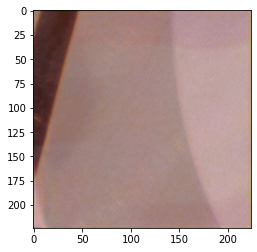

In [41]:
plt.imshow(reverse_transform(out[0].cpu().detach()))

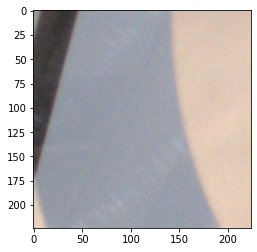

In [42]:
plt.imshow(reverse_transform(label))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


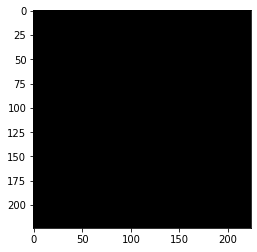

In [34]:
plt.imshow(out[0].cpu().permute(1,2,0).detach().numpy())

In [71]:
label.shape

torch.Size([3, 224, 224])

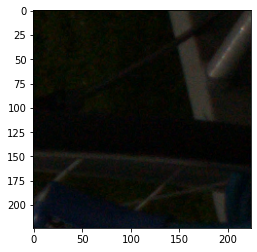

In [13]:
plt.imshow(label_img)

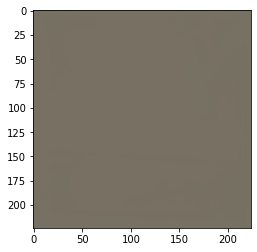

In [14]:
plt.imshow(out_img)